In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from scipy.stats import entropy
from skimage.filters import sobel
from skimage.measure import shannon_entropy
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import sklearn.neighbors
from sklearn.cluster import AffinityPropagation, MeanShift, OPTICS, Birch,estimate_bandwidth


In [3]:
base_dir = "clean_data"

In [4]:
# Initialize containers
pixel_data = []
brightness_data = []
contrast_data = []
edge_density_data = []
entropy_data = []

paths = glob(os.path.join(base_dir, "*"))

for path in paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    flat = img.flatten()
    if len(flat) != 42387 :
        print("O chuj kurwa")
        print(path)
        print(len(flat))
        
   
    pixel_data.extend(flat)
    brightness_data.append(np.mean(flat))
    contrast_data.append(np.std(flat))

    edge_map = sobel(img)
    edge_density_data.append(np.mean(edge_map))
    entropy_data.append(shannon_entropy(img))

pixel_data = np.array(pixel_data)

KeyboardInterrupt: 

In [14]:
def plot_three_histograms(data_list, title, xlabel, bins=50):
    plt.figure(figsize=(18, 4))

    plt.hist(data_list, bins=bins, color='gray', alpha=0.85)
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    


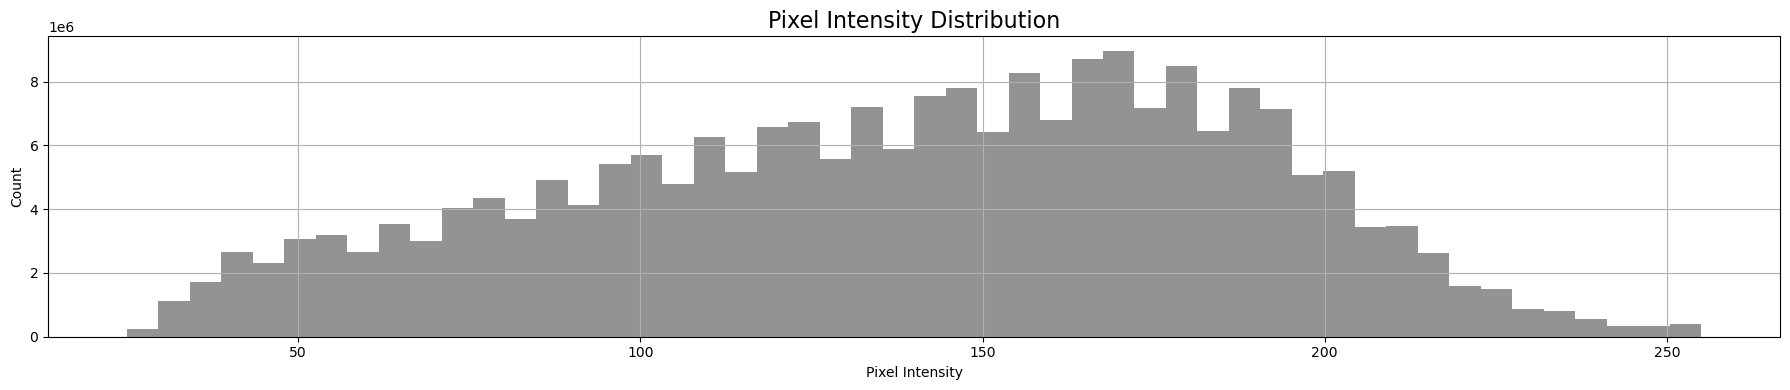

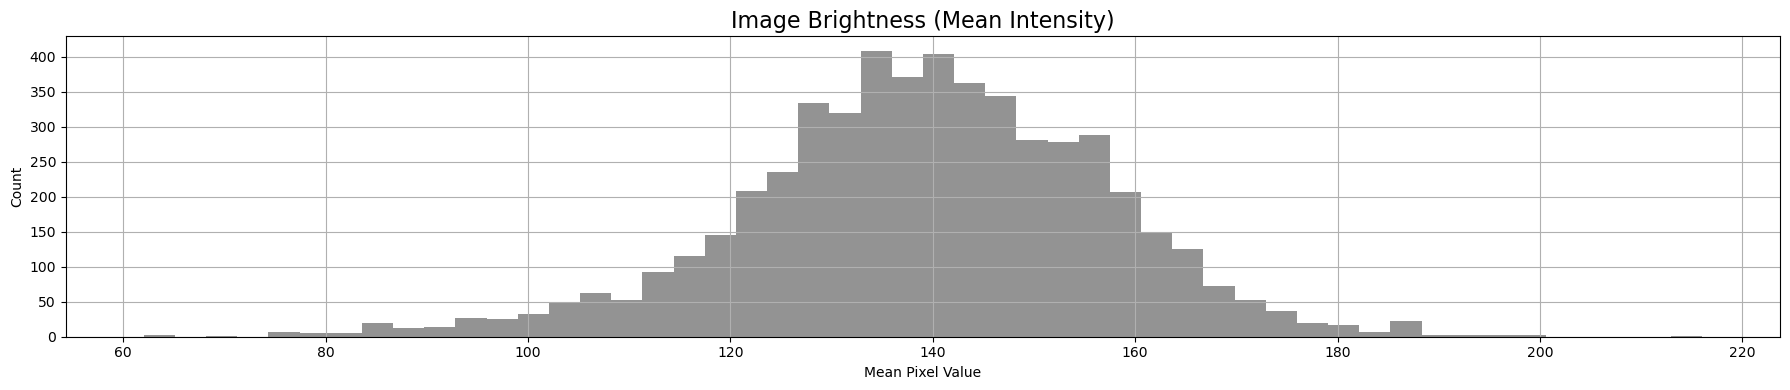

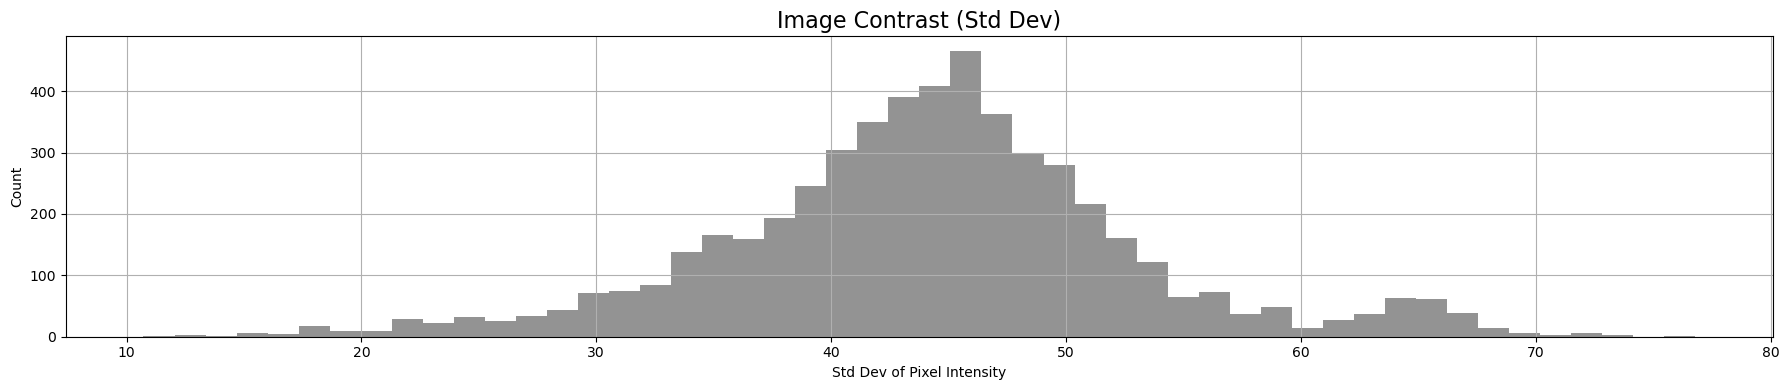

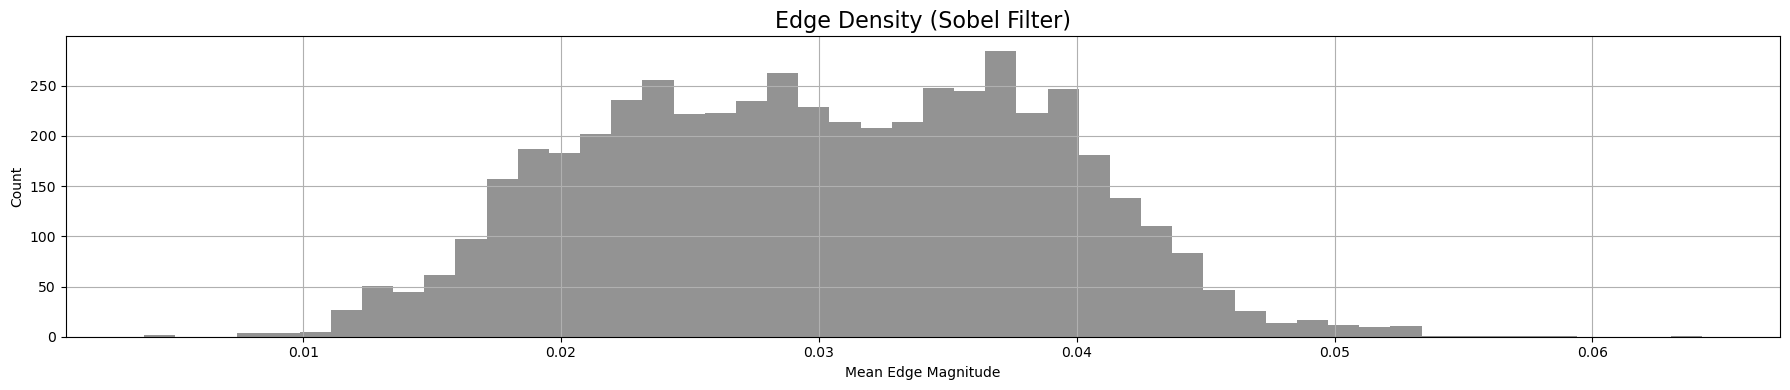

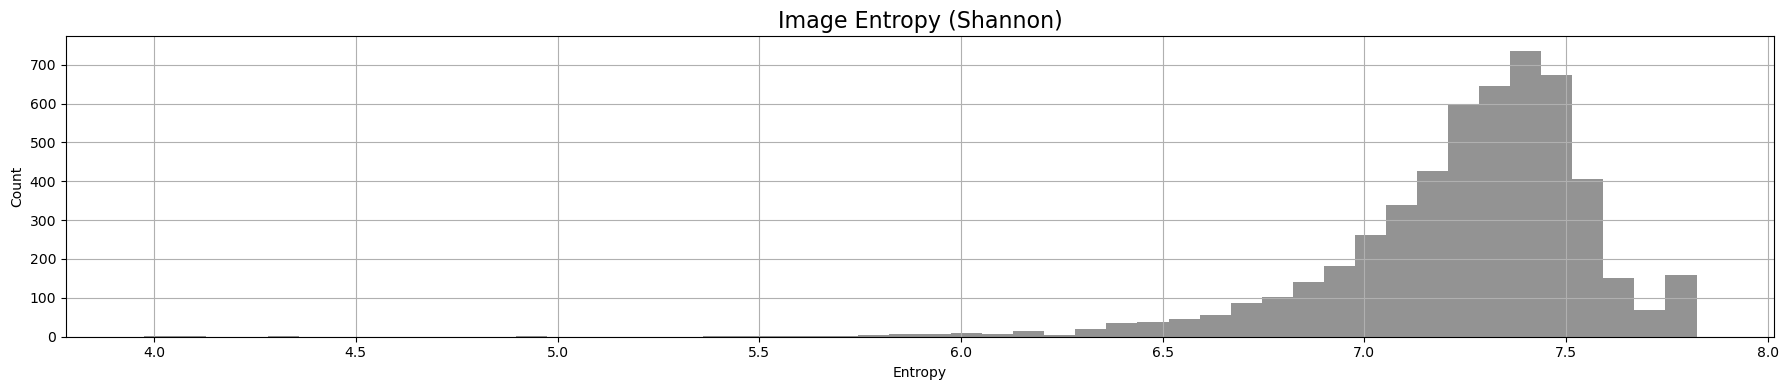

In [15]:
# 1. Pixel Intensity Histogram (all pixels across all images)
plot_three_histograms(pixel_data, "Pixel Intensity Distribution", "Pixel Intensity")

# 2. Brightness per Image
plot_three_histograms(brightness_data, "Image Brightness (Mean Intensity)", "Mean Pixel Value")

# 3. Contrast per Image
plot_three_histograms(contrast_data, "Image Contrast (Std Dev)", "Std Dev of Pixel Intensity")

# 4. Edge Density per Image
plot_three_histograms(edge_density_data, "Edge Density (Sobel Filter)", "Mean Edge Magnitude")

plot_three_histograms(entropy_data, "Image Entropy (Shannon)", "Entropy")


In [16]:
pixel_data=pixel_data.reshape(5228,42387)



In [17]:
entropy_data=np.array(entropy_data).reshape(-1,1)
edge_density_data=np.array(edge_density_data).reshape(-1,1)
contrast_data=np.array(contrast_data).reshape(-1,1)
brightness_data=np.array(brightness_data).reshape(-1,1)


In [18]:
pixel_data_all=np.concatenate((pixel_data, entropy_data), axis=1)
pixel_data_all =np.concatenate((pixel_data_all, edge_density_data), axis=1)
pixel_data_all =np.concatenate((pixel_data_all, contrast_data), axis=1)
pixel_data_all =np.concatenate((pixel_data_all, brightness_data), axis=1)
pixel_data_all.shape







(5228, 42391)

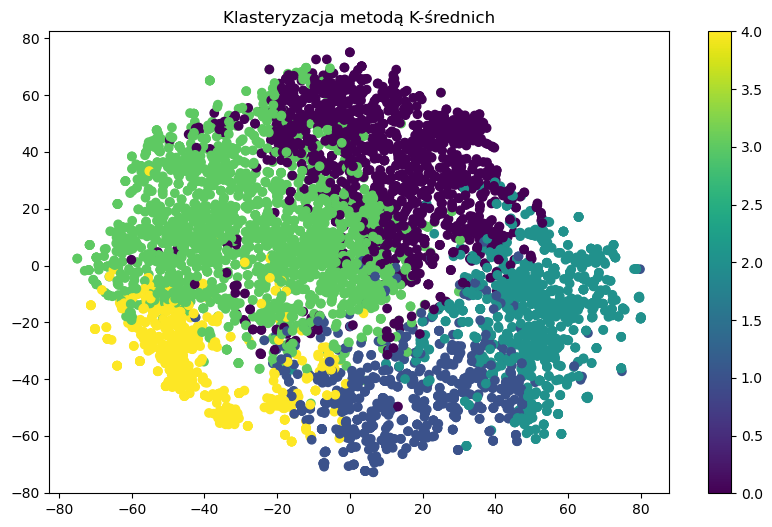


Metryki oceny dla K-średnich:
Współczynnik Silhouette: 0.089
Współczynnik Daviesa-Bouldina: 2.459
Współczynnik Calinskiego-Harabasza: 579.936


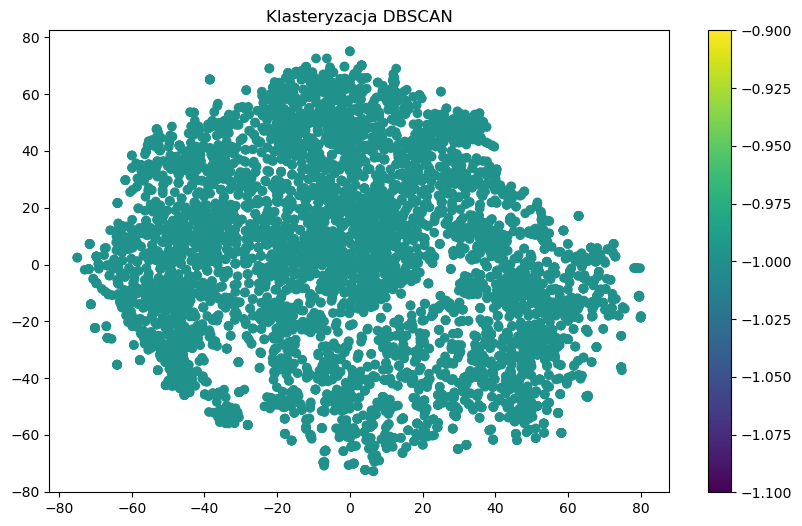


Uwaga: DBSCAN utworzył tylko jeden klaster - nie można obliczyć metryk


In [ ]:
# Skalowanie danych - ważne przed klasteryzacją
scaled_data = pixel_data_all
# Redukcja wymiarowości do 2D żeby móc zwizualizować
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(scaled_data)
# Funkcja do rysowania wyników klasteryzacji
def plot_clustering_results(tsne_data, labels, title):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()

# Funkcja do oceny jakości klasteryzacji
def evaluate_clustering(data, labels, model_name):
    if len(np.unique(labels)) > 1:  # Sprawdzamy czy jest więcej niż jeden klaster
        sil_score = silhouette_score(data, labels)
        db_score = davies_bouldin_score(data, labels)
        ch_score = calinski_harabasz_score(data, labels)
        
        print(f"\nMetryki oceny dla {model_name}:")
        print(f"Współczynnik Silhouette: {sil_score:.3f}")
        print(f"Współczynnik Daviesa-Bouldina: {db_score:.3f}")
        print(f"Współczynnik Calinskiego-Harabasza: {ch_score:.3f}")
    else:
        print(f"\nUwaga: {model_name} utworzył tylko jeden klaster - nie można obliczyć metryk")

# 1. Klasteryzacja metodą K-średnich

n_clusters = 5 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

plot_clustering_results(tsne_results, kmeans_labels, 'Klasteryzacja metodą K-średnich')
evaluate_clustering(scaled_data, kmeans_labels, 'K-średnich')


# 2. Klasteryzacja DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Możesz dostosować parametry
dbscan_labels = dbscan.fit_predict(scaled_data)

plot_clustering_results(tsne_results, dbscan_labels, 'Klasteryzacja DBSCAN')
evaluate_clustering(scaled_data, dbscan_labels, 'DBSCAN')




In [20]:
from torchvision import models, transforms
import torch
from PIL import Image
import os
import numpy as np
from tqdm import tqdm

# Wczytaj model bez klasyfikatora
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # usuń warstwę fc
model.eval()

# Transformacja obrazu - przygotowanie obrazów do modelu ResNet50:
# 1. Zmiana rozmiaru wszystkich obrazów na 224x224 pikseli (wymagany rozmiar dla ResNet)
# 2. Konwersja obrazu na tensor PyTorch
# 3. Normalizacja wartości pikseli według średniej i odchylenia standardowego 
#    używanych podczas treningu ImageNet (zbiór na którym trenowany był ResNet)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Ścieżka do folderu z danymi
data_dir = "D:/programy_studia/UM/ML_Project_2/clean_data"

# Lista na embeddingi i nazwy plików
embeddings = []
filenames = []

# Przetwarzanie wszystkich obrazów z paskiem postępu
image_files = [f for f in os.listdir(data_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
for filename in tqdm(image_files, desc="Przetwarzanie obrazów"):
    img_path = os.path.join(data_dir, filename)
    try:
        # Wczytaj i przekształć obraz
        img = Image.open(img_path).convert("RGB")
        x = transform(img).unsqueeze(0)
        
        # Wyciągnij cechy
        with torch.no_grad():
            embedding = model(x).squeeze().numpy()
            embeddings.append(embedding)
            filenames.append(filename)
            
    except Exception as e:
        print(f"Błąd podczas przetwarzania {filename}: {e}")

# Konwersja listy na tablicę numpy
embeddings_array = np.array(embeddings)
print("Kształt tablicy z cechami:", embeddings_array.shape)
print("Liczba przetworzonych obrazów:", len(filenames))

c:\Users\micae\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\micae\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Przetwarzanie obrazów: 100%|██████████| 5228/5228 [05:19<00:00, 16.36it/s]

Kształt tablicy z cechami: (5228, 2048)
Liczba przetworzonych obrazów: 5228


In [ ]:
embeddings_array2=np.concatenate((embeddings_array, entropy_data), axis=1)
embeddings_array2 =np.concatenate((embeddings_array2, edge_density_data), axis=1)
embeddings_array2 =np.concatenate((embeddings_array2, contrast_data), axis=1)
embeddings_array2 =np.concatenate((embeddings_array2, brightness_data), axis=1)
embeddings_array2.shape

(5228, 2052)

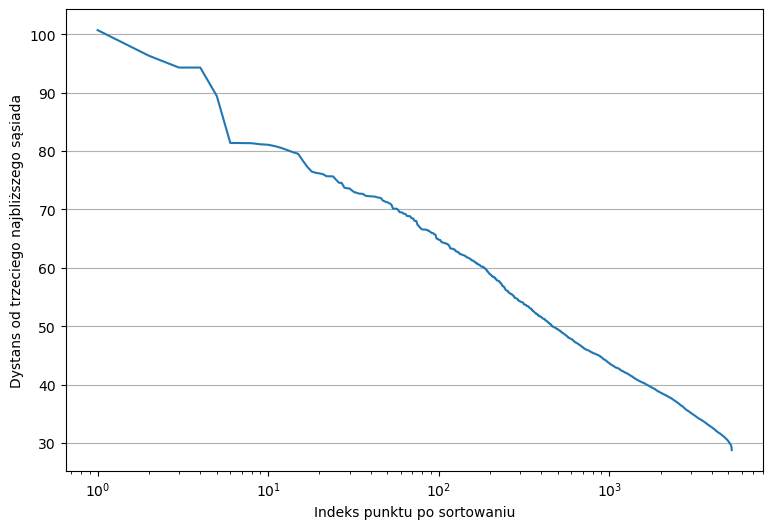

In [ ]:
minPts = 4104
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=minPts).fit(embeddings_array2)
distances, indices = nbrs.kneighbors(embeddings_array2)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od trzeciego najbliższego sąsiada')
ax1.plot(list(range(1,embeddings_array2.shape[0]+1)), distanceDec)

plt.xscale('log')
plt.grid(axis='y')

plt.show()

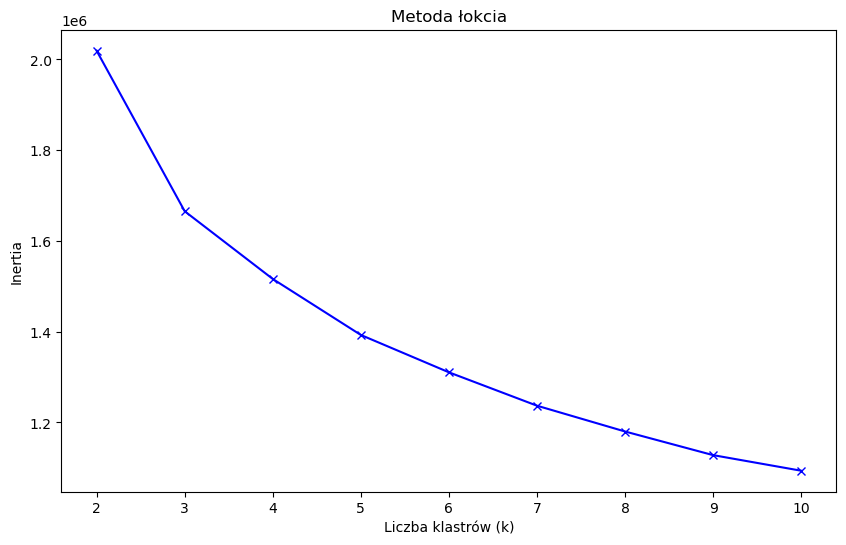

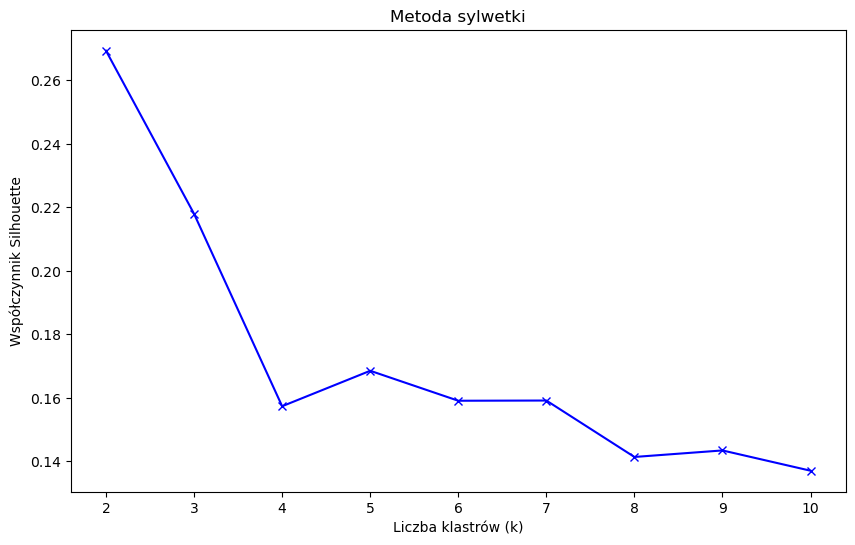

In [ ]:

inertias = []
k_range = range(2, 11)
for k in k_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    kmeans_test.fit(embeddings_array2)
    inertias.append(kmeans_test.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bx-')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Inertia')
plt.title('Metoda łokcia')
plt.show()

# Metoda sylwetki
silhouette_scores = []
for k in k_range:
    kmeans_test = KMeans(n_clusters=k, random_state=42)
    labels = kmeans_test.fit_predict(embeddings_array2)
    silhouette_scores.append(silhouette_score(embeddings_array2, labels))

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'bx-')
plt.xlabel('Liczba klastrów (k)')
plt.ylabel('Współczynnik Silhouette')
plt.title('Metoda sylwetki')
plt.show()

In [24]:
import plotly.graph_objects as go
# Skalowanie danych - ważne przed klasteryzacją
scaler = StandardScaler()
scaled_data = scaler.fit_transform(embeddings_array2)

# Redukcja wymiarowości do 3D żeby móc zwizualizować
tsne = TSNE(n_components=3, random_state=42)
tsne_results = tsne.fit_transform(scaled_data)

# Funkcja do rysowania wyników klasteryzacji w 3D używając plotly
def plot_clustering_results_3d(tsne_data, labels, title):
    fig = go.Figure(data=[go.Scatter3d(
        x=tsne_data[:, 0],
        y=tsne_data[:, 1],
        z=tsne_data[:, 2],
        mode='markers',
        marker=dict(
            size=5,
            color=labels,
            colorscale='Viridis',
            showscale=True
        )
    )])
    
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='TSNE 1',
            yaxis_title='TSNE 2',
            zaxis_title='TSNE 3'
        ),
        width=1000,
        height=600
    )
    fig.show()

# Funkcja do oceny jakości klasteryzacji i wyświetlania przykładowych obrazów z klastrów
def evaluate_clustering_and_show_examples(data, labels, model_name, folder_path, num_examples=20):
    # Get list of image files from folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    image_paths = [os.path.join(folder_path, f) for f in image_files]
    
    if len(np.unique(labels)) > 1:
        sil_score = silhouette_score(data, labels)
        db_score = davies_bouldin_score(data, labels)
        ch_score = calinski_harabasz_score(data, labels)
        
        print(f"\nMetryki oceny dla {model_name}:")
        print(f"Współczynnik Silhouette: {sil_score:.3f}")
        print(f"Współczynnik Daviesa-Bouldina: {db_score:.3f}")
        print(f"Współczynnik Calinskiego-Harabasza: {ch_score:.3f}")
        
        # Wyświetlanie informacji o klastrach
        unique_labels = np.unique(labels)
        for label in unique_labels:
            cluster_indices = np.where(labels == label)[0]
            cluster_files = [image_files[i] for i in cluster_indices]
            
            # Liczenie procentów dla każdej kategorii
            covid_count = sum('COVID' in f for f in cluster_files)
            pneumonia_count = sum('PNEUMONIA' in f for f in cluster_files)
            normal_count = sum('NORMAL' in f for f in cluster_files)
            total = len(cluster_files)
            
            print(f"\nKlaster {label}:")
            print(f"Liczba obrazów w klastrze: {total}")
            print(f"COVID: {covid_count/total*100:.1f}%")
            print(f"PNEUMONIA: {pneumonia_count/total*100:.1f}%")
            print(f"NORMAL: {normal_count/total*100:.1f}%")
    else:
        print(f"\nUwaga: {model_name} utworzył tylko jeden klaster - nie można obliczyć metryk")

# 1. Klasteryzacja metodą K-średnich
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)

plot_clustering_results_3d(tsne_results, kmeans_labels, 'Klasteryzacja metodą K-średnich')
evaluate_clustering_and_show_examples(scaled_data, kmeans_labels, 'K-średnich', 'clean_data')

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(scaled_data)

plot_clustering_results_3d(tsne_results, gmm_labels, 'Klasteryzacja metodą Gaussian Mixture')
evaluate_clustering_and_show_examples(scaled_data, gmm_labels, 'Gaussian Mixture', 'clean_data')

# Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=n_clusters)
agg_labels = agg.fit_predict(scaled_data)

plot_clustering_results_3d(tsne_results, agg_labels, 'Klasteryzacja hierarchiczna')
evaluate_clustering_and_show_examples(scaled_data, agg_labels, 'Agglomerative Clustering', 'clean_data')
# Birch
birch = Birch(threshold=0.2)
birch_labels = birch.fit_predict(scaled_data)

# Zapisywanie ścieżek do zdjęć dla każdego klastra
cluster_1 = [image_files[i] for i in range(len(birch_labels)) if birch_labels[i] == 0]
cluster_2 = [image_files[i] for i in range(len(birch_labels)) if birch_labels[i] == 1]
cluster_3 = [image_files[i] for i in range(len(birch_labels)) if birch_labels[i] == 2]

plot_clustering_results_3d(tsne_results, birch_labels, 'Klasteryzacja metodą Birch')
evaluate_clustering_and_show_examples(scaled_data, birch_labels, 'Birch', 'clean_data')


# # 2. Klasteryzacja DBSCAN
# dbscan = DBSCAN(eps=80, min_samples=4104)  # Możesz dostosować parametry
# dbscan_labels = dbscan.fit_predict(scaled_data)

# plot_clustering_results(embeddings_array2, dbscan_labels, 'Klasteryzacja DBSCAN')
# evaluate_clustering(scaled_data, dbscan_labels, 'DBSCAN')





Metryki oceny dla K-średnich:
Współczynnik Silhouette: 0.085
Współczynnik Daviesa-Bouldina: 2.946
Współczynnik Calinskiego-Harabasza: 617.755

Klaster 0:
Liczba obrazów w klastrze: 1522
COVID: 1.0%
PNEUMONIA: 32.7%
NORMAL: 66.3%

Klaster 1:
Liczba obrazów w klastrze: 2099
COVID: 3.5%
PNEUMONIA: 60.3%
NORMAL: 36.2%

Klaster 2:
Liczba obrazów w klastrze: 1607
COVID: 95.6%
PNEUMONIA: 2.2%
NORMAL: 2.1%



Metryki oceny dla Gaussian Mixture:
Współczynnik Silhouette: 0.085
Współczynnik Daviesa-Bouldina: 2.946
Współczynnik Calinskiego-Harabasza: 617.755

Klaster 0:
Liczba obrazów w klastrze: 1522
COVID: 1.0%
PNEUMONIA: 32.7%
NORMAL: 66.3%

Klaster 1:
Liczba obrazów w klastrze: 2099
COVID: 3.5%
PNEUMONIA: 60.3%
NORMAL: 36.2%

Klaster 2:
Liczba obrazów w klastrze: 1607
COVID: 95.6%
PNEUMONIA: 2.2%
NORMAL: 2.1%



Metryki oceny dla Agglomerative Clustering:
Współczynnik Silhouette: 0.078
Współczynnik Daviesa-Bouldina: 2.910
Współczynnik Calinskiego-Harabasza: 529.536

Klaster 0:
Liczba obrazów w klastrze: 2834
COVID: 9.1%
PNEUMONIA: 56.0%
NORMAL: 34.8%

Klaster 1:
Liczba obrazów w klastrze: 1393
COVID: 97.8%
PNEUMONIA: 0.8%
NORMAL: 1.4%

Klaster 2:
Liczba obrazów w klastrze: 1001
COVID: 0.4%
PNEUMONIA: 20.1%
NORMAL: 79.5%



Metryki oceny dla Birch:
Współczynnik Silhouette: 0.082
Współczynnik Daviesa-Bouldina: 3.106
Współczynnik Calinskiego-Harabasza: 566.710

Klaster 0:
Liczba obrazów w klastrze: 1916
COVID: 0.8%
PNEUMONIA: 18.3%
NORMAL: 80.8%

Klaster 1:
Liczba obrazów w klastrze: 1599
COVID: 98.6%
PNEUMONIA: 0.4%
NORMAL: 1.0%

Klaster 2:
Liczba obrazów w klastrze: 1713
COVID: 1.9%
PNEUMONIA: 84.2%
NORMAL: 13.8%


In [25]:
print(len(cluster_1))

cluster_1[1]

1916


'COVID_1265.png'

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shap
import lime
import lime.lime_tabular
import torchvision.transforms as transforms
from PIL import Image
from torchvision import models
import torch.nn.functional as F
import seaborn as sns

# Przygotowanie danych dla Random Forest
X = scaled_data
y = birch_labels

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

# Tworzenie i trenowanie modelu Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Ocena modelu
train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)

print(f"Dokładność na zbiorze treningowym: {train_score:.4f}")
print(f"Dokładność na zbiorze testowym: {test_score:.4f}")

# Feature importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1][:20]  # Top 20 features

plt.figure(figsize=(10, 6))
plt.title('Top 20 Feature Importances')
plt.bar(range(20), importances[indices])
plt.xticks(range(20), [f'feature_{i}' for i in indices], rotation=45)
plt.tight_layout()
plt.show()

# SHAP values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test[:100, indices])  # Using only top 20 features

# Plot SHAP values for each class
for class_idx in range(len(shap_values)):
    plt.figure(figsize=(15, 8))
    shap.summary_plot(shap_values[class_idx], 
                     X_test[:100, indices],
                     feature_names=[f"feature_{i}" for i in indices],
                     show=False)
    plt.title(f'SHAP Summary Plot for Class {class_idx}')
    plt.tight_layout()
    plt.show()
    plt.close()

# LIME explanation for a single instance
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    X_train[:, indices],  # Use only top 20 features
    mode="classification", 
    training_labels=y_train,
    feature_names=[f"feature_{i}" for i in indices]
)

# Plot LIME explanations for each class
unique_classes = np.unique(y_test)

for i, class_label in enumerate(unique_classes):
    # Find first instance of this class in test set
    class_idx = np.where(y_test == class_label)[0][0]
    
    # Get explanation for this instance
    exp = explainer_lime.explain_instance(
        X_test[class_idx, indices],  # Use only top 20 features
        rf_model.predict_proba,
        num_features=20
    )
    
    plt.figure(figsize=(15, 8))
    exp.as_pyplot_figure()
    plt.title(f'LIME Feature Importance for Class {class_label}')
    plt.tight_layout()
    plt.show()
    plt.close()

SyntaxError: invalid syntax (3688568652.py, line 22)